
# QML — Breast Cancer (QSVM) 

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector


### Carga y preparación de datos

- Dataset: **Breast Cancer Wisconsin** (`sklearn.datasets.load_breast_cancer`).
- División **train/test** estratificada (evitamos *data leakage*).

In [2]:
TEST_SIZE = 0.2
RANDOM_STATE = 52

In [3]:
data = load_breast_cancer()
Xfull = data.data
cols = data.feature_names
y = data.target

In [4]:
X_train_full, X_test_full, y_train, y_test = train_test_split(
    Xfull, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

In [5]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_train_full, y_train = rus.fit_resample(X_train_full, y_train)

<Axes: >

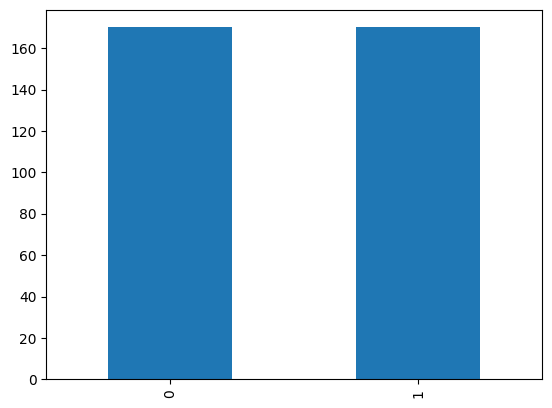

In [6]:
import pandas as pd

pd.Series(y_train).value_counts().plot(kind='bar')

## Feature Selection

- **RFECV (Random Forest)** para filtrar columnas informativas (ajustado solo con *train*).
- **mutual_info_classif** para obtener la informacion mas importante
- **PCA/ICA → 4 componentes** para ajustarse a **4 qubits**.
- **Criterio clinico** para tomar las variables que los doctores creen mas importantes

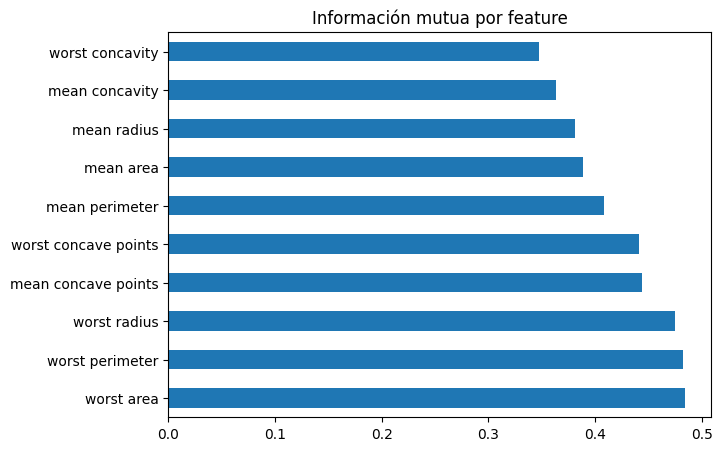

In [7]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

mi = mutual_info_classif(X_train_full, y_train, random_state=1000)
mi_series = pd.Series(mi, index=data.feature_names).sort_values(ascending=False)

mi_series.head(10).plot(kind="barh", figsize=(7,5), title="Información mutua por feature")
plt.show()


In [8]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVC

svc = SVC(kernel="linear")
rfe = RFE(svc, n_features_to_select=4)
rfe.fit(X_train_full, y_train)

ranking = pd.Series(rfe.ranking_, index=data.feature_names).sort_values()
ranking.head(10)

worst compactness       1
worst concavity         1
worst concave points    1
worst symmetry          1
texture error           2
worst radius            3
mean concavity          4
mean radius             5
worst smoothness        6
mean concave points     7
dtype: int64

In [9]:
COMPONENTS = 4

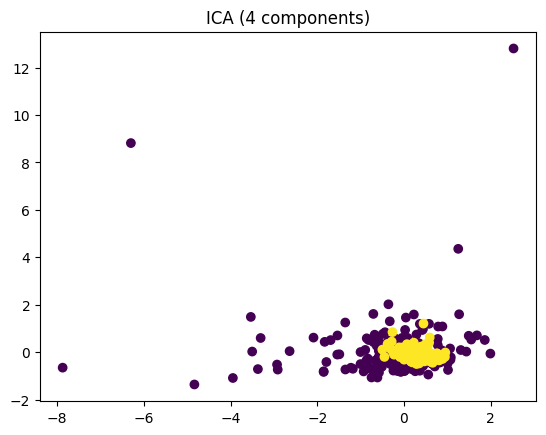

In [10]:
from sklearn.decomposition import FastICA

ica = FastICA(n_components=COMPONENTS, random_state=52)
X_ica = ica.fit_transform(X_train_full)
plt.scatter(X_ica[:,0], X_ica[:,1], c=y_train)
plt.title(f"ICA ({COMPONENTS} components)")
plt.show()


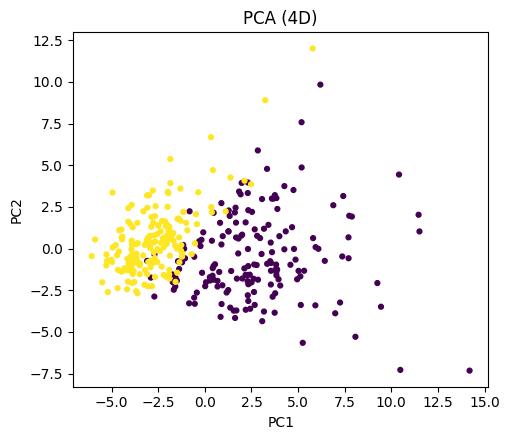

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_sem_scaled = scaler.fit_transform(X_train_full)
pca = PCA(n_components=COMPONENTS, random_state=42)
X_sem_pca = pca.fit_transform(X_sem_scaled)

plt.figure(figsize=(5.2, 4.5))
plt.scatter(X_sem_pca[:,0], X_sem_pca[:,1], c=y_train, s=12)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title(f"PCA ({COMPONENTS}D)")
plt.tight_layout()
plt.show()


worst perimeter           0.1868
worst area                0.1512
worst radius              0.1380
mean concave points       0.1205
worst concave points      0.1186
mean perimeter            0.0501
mean concavity            0.0418
mean radius               0.0395
worst concavity           0.0324
worst texture             0.0270
mean texture              0.0246
mean area                 0.0243
worst smoothness          0.0235
area error                0.0217


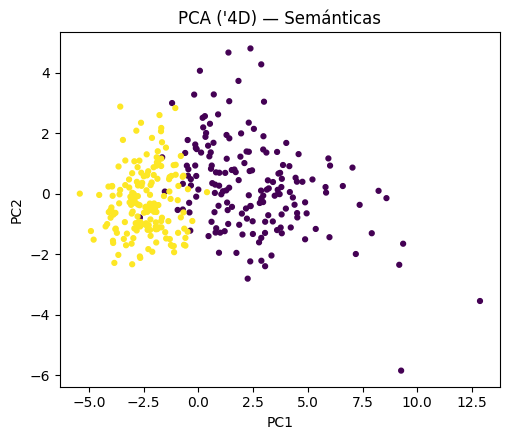

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# tecnica de selección de features basada en Random Forest

rf_base = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# RFECV - Recursive Feature Elimination with Cross-Validation
rfecv = RFECV(
    estimator=rf_base,
    step=1,
    cv=cv,
    scoring="accuracy", 
    n_jobs=-1
)
rfecv.fit(X_train_full, y_train) 
X_train_sel = rfecv.transform(X_train_full)

selected = cols[rfecv.support_]
importances = rfecv.estimator_.feature_importances_
order = np.argsort(importances)[::-1]

for name, imp in zip(selected[order], importances[order]):
    print(f"{name:<25} {imp:.4f}")

scaler_rfecv = StandardScaler()
X_sem_scaled_rfecv = scaler_rfecv.fit_transform(X_train_sel)
pca_rfecv = PCA(n_components=COMPONENTS, random_state=42)
X_sem_pca_rfecv = pca_rfecv.fit_transform(X_sem_scaled_rfecv)

plt.figure(figsize=(5.2, 4.5))
plt.scatter(X_sem_pca_rfecv[:,0], X_sem_pca_rfecv[:,1], c=y_train, s=12)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title(f"PCA ('{COMPONENTS}D) — Semánticas")
plt.tight_layout()
plt.show()


In [50]:
USE = "SELECTED"  # Options: "PCA", "ICA", "SELECTED", "RFECV_PCA"

SELECTED == criterio clinico

In [51]:
if USE == "PCA":
    X_train = X_sem_pca
    X_test_scaled = scaler.transform(X_test_full)
    X_test = pca.transform(X_test_scaled)
elif USE == "ICA":
    X_train = X_ica
    X_test = ica.transform(X_test_full)
elif USE == "SELECTED":
    selected_cols = ["worst concave points", "worst concavity", "worst perimeter", "worst area"]
    idx = [list(cols).index(c) for c in selected_cols]
    X_train = X_train_full[:, idx].astype(float)
    X_test = X_test_full[:, idx].astype(float)
elif USE == "RFECV_PCA":
    X_train = X_sem_pca_rfecv
    X_test_sel = rfecv.transform(X_test_full)
    X_test_sem_scaled_rfecv = scaler_rfecv.transform(X_test_sel)
    X_test = pca_rfecv.transform(X_test_sem_scaled_rfecv)

In [52]:
print("Using feature selection method:", USE)
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Using feature selection method: SELECTED
Train shape: (340, 4)
Test shape: (114, 4)



## Scatter plots

In [53]:
import numpy as np

def scale_to_pi(x_col):
    return 2 * np.pi * (x_col - np.min(x_col)) / (np.max(x_col) - np.min(x_col)) - np.pi

In [54]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_all_feature_pairs(X_orig, y, feature_names=None, X_pi=None, model=None):
    n_features = X_orig.shape[1]
    pairs = list(itertools.combinations(range(n_features), 2))
    print(f"Generando {len(pairs)} pares de gráficos con {n_features} features...\n")

    if feature_names is None:
        if model is not None:
            feature_names = [f"PCA{i+1}" for i in range(n_features)]
        else:
            feature_names = [f"Feature {i+1}" for i in range(n_features)]

    for i, j in pairs:
        fig, axes = plt.subplots(1, 2 if X_pi is not None else 1, figsize=(10, 5))

        ax0 = axes[0] if X_pi is not None else axes
        sc = ax0.scatter(X_orig[:, i], X_orig[:, j], c=y, s=18, alpha=0.7)
        ax0.set_title("Espacio original" if model is None else "Espacio PCA")
        ax0.set_xlabel(feature_names[i])
        ax0.set_ylabel(feature_names[j])
        fig.colorbar(sc, ax=ax0, label="Clase")

        if X_pi is not None:
            ax1 = axes[1]
            ax1.scatter(X_pi[:, i], X_pi[:, j], c=y, s=18, alpha=0.7)
            ax1.set_title("Escalado a [-π, π]")
            ax1.set_xlabel(f"{feature_names[i]} (rad)")
            ax1.set_ylabel(f"{feature_names[j]} (rad)")
            ax1.set_xlim(-np.pi, np.pi)
            ax1.set_ylim(-np.pi, np.pi)
            fig.colorbar(sc, ax=ax1, label="Clase")

        plt.suptitle(f"{feature_names[i]} vs {feature_names[j]}")
        plt.tight_layout()
        plt.show()

Generando 6 pares de gráficos con 4 features...



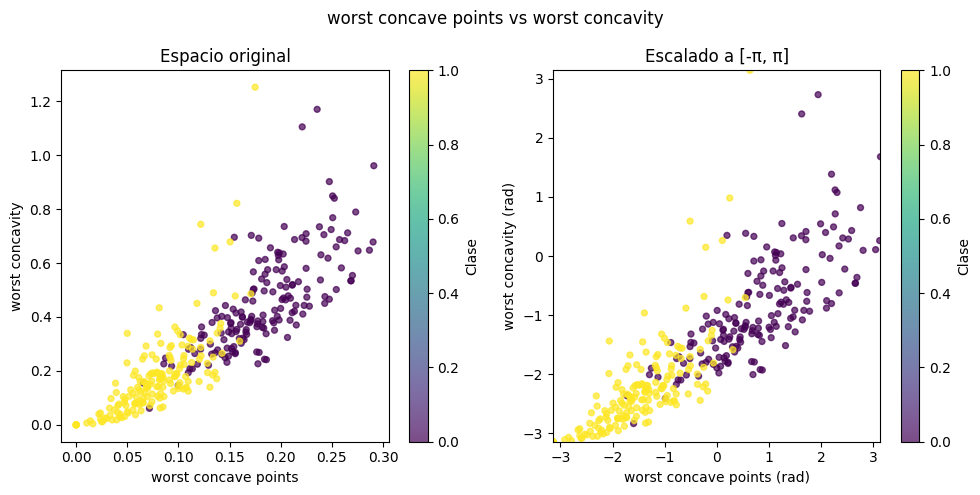

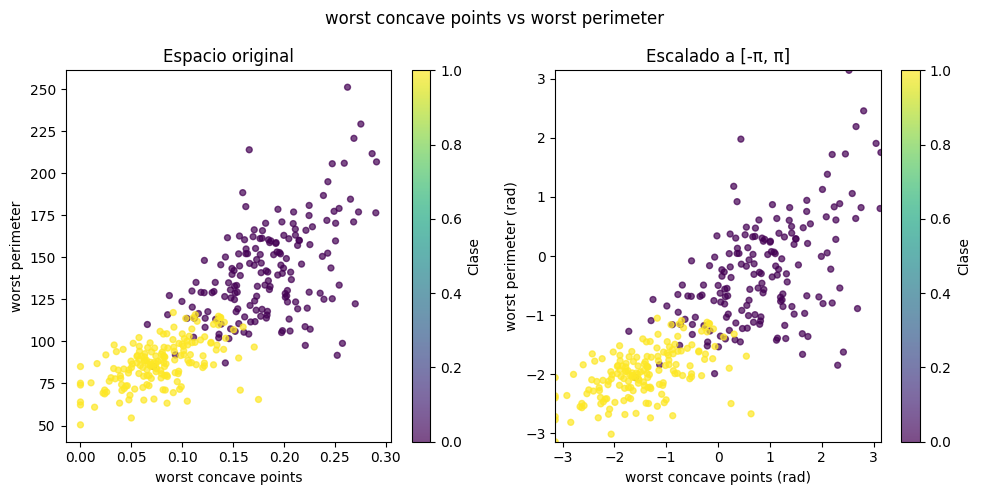

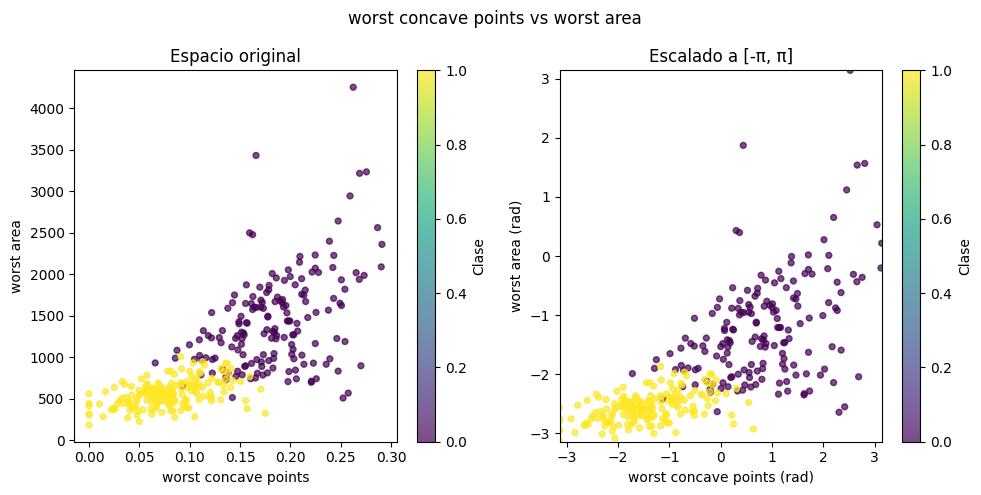

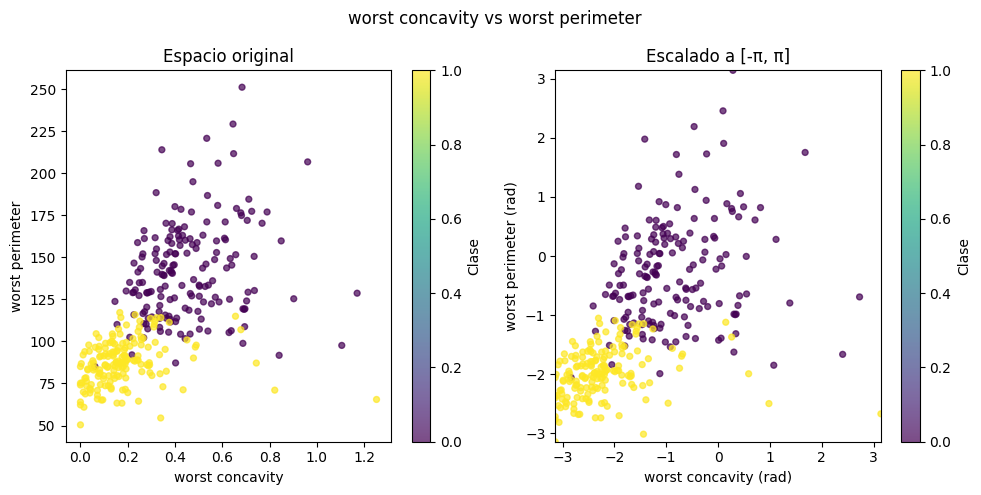

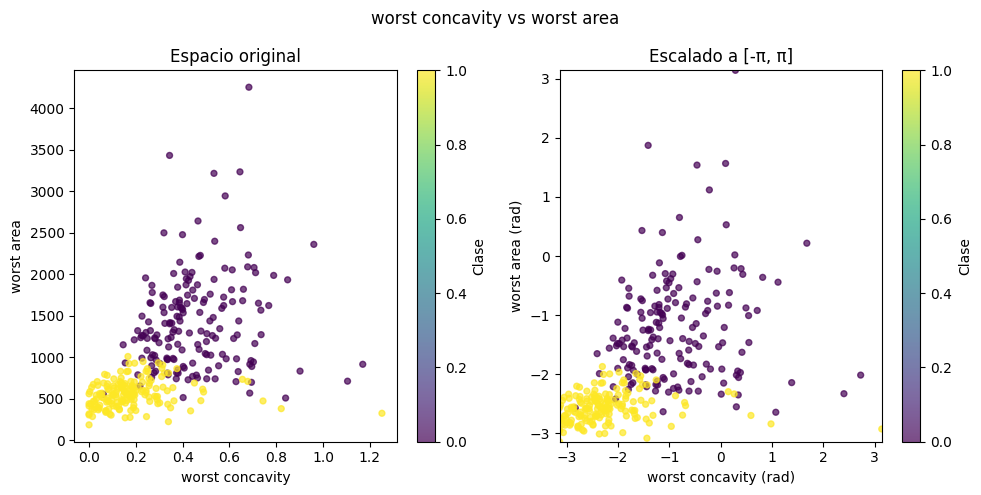

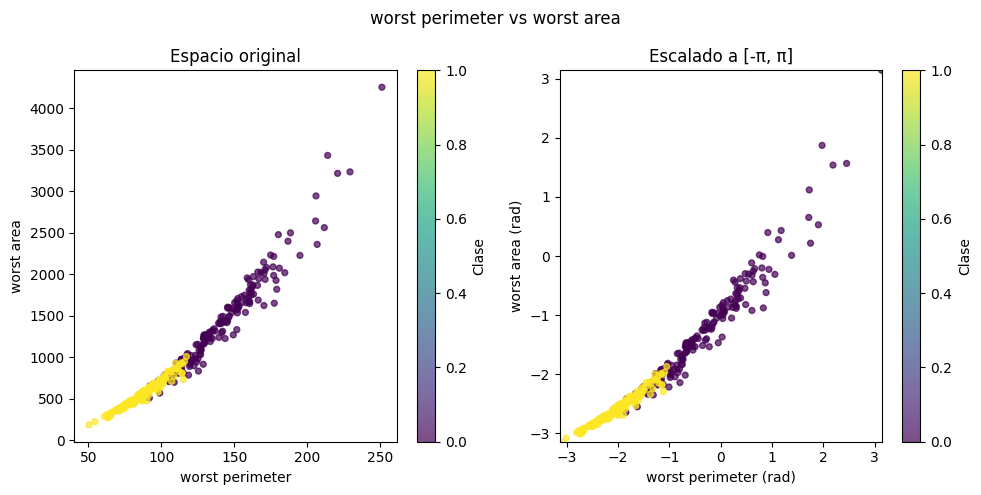

In [55]:
import matplotlib.pyplot as plt


X_train_pi = X_train.copy()
X_test_pi = X_test.copy()

for i in range(X_train.shape[1]):
    X_train_pi[:,i] = scale_to_pi(X_train_pi[:,i])

for i in range(X_test.shape[1]):
    X_test_pi[:,i] = scale_to_pi(X_test_pi[:,i])

if USE == "SELECTED":
    plot_all_feature_pairs(X_train, y_train, feature_names=selected_cols, X_pi=X_train_pi)
else:
    plot_all_feature_pairs(X_train, y_train, X_pi=X_train_pi, model=ica)


## Quantum Builder

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit
from joblib import Parallel, delayed
import numpy as np

In [57]:
def list_pairs(n_qubits, mode):
    if mode == "linear": return [(i, i+1) for i in range(n_qubits-1)]
    if mode == "ring":   return [(i, (i+1) % n_qubits) for i in range(n_qubits)]
    if mode == "full":   return [(i, j) for i in range(n_qubits) for j in range(i+1, n_qubits)]
    if mode == "circular":   return [(i, (i + 1) % n_qubits) for i in range(n_qubits)]
    if mode == "start":   return [(0, j) for j in range(1, n_qubits)]
    return mode

def apply_data_gate(qc, gate_name, qubit, angle):
    g = gate_name.lower()
    if g == "rx": qc.rx(angle, qubit)
    elif g == "ry": qc.ry(angle, qubit)
    elif g == "rz": qc.rz(angle, qubit)
    elif g == "h": qc.h(qubit)
    elif g == "x": qc.x(qubit)
    elif g == "y": qc.y(qubit)
    elif g == "z": qc.z(qubit)
    elif g == "s": qc.s(qubit)
    elif g == "t": qc.t(qubit)
    else: raise ValueError(f"Puerta {gate_name} no soportada en encode")

def apply_two_qubit_gate(qc, gate_name, q0, q1, angle=None):
    g = gate_name.lower()
    if g == "cx": qc.cx(q0, q1); return
    if g == "cz": qc.cz(q0, q1); return
    if g == "swap": qc.swap(q0, q1); return
    if g == "crx":
        if angle is None: raise ValueError("CRX requiere ángulo")
        qc.crx(angle, q0, q1); return
    if g == "cry":
        if angle is None: raise ValueError("CRY requiere ángulo")
        qc.cry(angle, q0, q1); return
    if g == "crz":
        if angle is None: raise ValueError("CRZ requiere ángulo")
        qc.crz(angle, q0, q1); return
    if g == "rzz":
        if angle is None: raise ValueError("RZZ requiere ángulo")
        qc.rzz(angle, q0, q1); return
    raise ValueError(f"Puerta 2-qubits {gate_name} no soportada")


def quantum_kernel_matrix_recipe(XA, XB, n_qubits, recipe, params):
    SA = [build_circuit_from_recipe(x, n_qubits, recipe, params)[0] for x in XA]
    SB = [build_circuit_from_recipe(x, n_qubits, recipe, params)[0] for x in XB]
    K = np.empty((len(SA), len(SB)))
    for i, sa in enumerate(SA):
        for j, sb in enumerate(SB):
            K[i, j] = abs(sa.data.conj().T @ sb.data)**2
    return K

def build_circuit_from_recipe(x_vec, n_qubits, recipe, params):
    x = np.asarray(x_vec, dtype=float); assert len(x)==n_qubits
    qc = QuantumCircuit(n_qubits)
    norm = float(np.linalg.norm(x))
    mean = float(np.mean(x))
    for layer in recipe:
        ltype = layer.get("type","").lower()
        ops = layer.get("ops",[])
        if ltype == "encode":
            for op in ops:
                gate = op["gate"]; q = int(op["on"])
                src = op.get("source","x")
                scale = op.get("scale", 1.0)
                pkey  = op.get("param_key", None)
                # ángulo para encode
                if gate.lower() in ["rx","ry","rz"]:
                    if src == "x":
                        if scale is None and pkey is not None:
                            ang = float(params.get(pkey, 0.3)) * x[q] 
                        else:
                            ang = float(scale) * x[q]
                    elif src == "norm":
                        if scale is None and pkey is not None:
                            ang = float(params.get(pkey, 0.3)) * norm
                        else:
                            ang = float(scale) * norm
                    elif src == "mean":
                        if scale is None and pkey is not None:
                            ang = float(params.get(pkey, 0.3)) * mean
                        else:
                            ang = float(scale) * mean
                    elif src == "const":
                        ang = float(scale)
                    else:
                        raise ValueError("source no reconocido")
                    apply_data_gate(qc, gate, q, ang)
                else:
                    apply_data_gate(qc, gate, q, None)
        elif ltype == "var":
            for op in ops:
                gate = op["gate"].lower()
                on = op.get("on","all")
                key = op["param_key"]
                ang = float(params.get(key, 0.0))
                targets = list(range(n_qubits)) if on=="all" else ([on] if isinstance(on,int) else list(on))
                for q in targets:
                    apply_data_gate(qc, gate, q, ang)

        elif ltype == "entangle":
            for op in ops:
                gate = op["gate"].lower()
                pair_mode = op.get("pair","ring")
                pairs = list_pairs(n_qubits, pair_mode)
                angle_spec = op.get("angle", None)
                key = op.get("param_key", None)
                for (q0,q1) in pairs:
                    if gate in ["cx","cz","swap"]:
                        apply_two_qubit_gate(qc, gate, q0, q1)
                    else:
                        if isinstance(angle_spec,(int,float)):
                            ang = float(angle_spec)
                        elif angle_spec == "norm":
                            phi = float(params.get(key, 0.5)); ang = phi * norm
                        elif angle_spec == "prod":
                            eta = float(params.get(key, 0.15)); ang = eta * (x[q0]*x[q1])
                        elif angle_spec == "param":
                            ang = float(params.get(key, 0.2))
                        else:
                            raise ValueError("angle mal especificado")
                        apply_two_qubit_gate(qc, gate, q0, q1, ang)
        if layer.get("barrier", False): qc.barrier()
    return Statevector.from_instruction(qc), qc



In [ ]:
def qsvm_cv_acc(X, y, n_qubits, recipe, params, n_splits=3, C=1.0):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    accs=[]
    for tr, va in skf.split(X,y):
        Ktr = quantum_kernel_matrix_recipe(X[tr], X[tr], n_qubits, recipe, params)
        Kva = quantum_kernel_matrix_recipe(X[va], X[tr], n_qubits, recipe, params)
        clf = SVC(kernel="precomputed", C=C).fit(Ktr, y[tr])
        accs.append(clf.score(Kva, y[va]))
    return float(np.mean(accs))

def kernel_alignment(X, y, n_qubits, recipe, params):
    ypm = np.where(y==1, 1.0, -1.0)
    Y = np.outer(ypm, ypm)
    K = quantum_kernel_matrix_recipe(X, X, n_qubits, recipe, params)
    n = K.shape[0]
    H = np.eye(n) - np.ones((n,n))/n
    Kc = H @ K @ H; Yc = H @ Y @ H
    num = np.sum(Kc*Yc); den = np.sqrt(np.sum(Kc*Kc)*np.sum(Yc*Yc))+1e-12
    return float(num/den)  # en [-1,1]

def objective(params, X, y, n_qubits, recipe, mode="cv_acc", C=1.0):
    if mode=="cv_acc":
        return qsvm_cv_acc(X, y, n_qubits, recipe, params, C=C)  # maximizar
    elif mode=="alignment":
        return kernel_alignment(X, y, n_qubits, recipe, params)  # maximizar
    else:
        raise ValueError("mode debe ser 'cv_acc' o 'alignment'")

def finite_diff_optimize(X, y, n_qubits, recipe, params0, steps=20, lr=0.1, eps=5e-2, 
                         mode="cv_acc", C=1.0, clip=None, verbose=True):
    keys = list(params0.keys())
    vec  = np.array([params0[k] for k in keys], dtype=float)
    hist = []

    def vec_to_params(v): return {k: float(val) for k, val in zip(keys, v)}

    for t in range(steps):
        grad = np.zeros_like(vec)
        for i in range(len(vec)):
            v_plus  = vec.copy(); v_plus[i]  += eps
            v_minus = vec.copy(); v_minus[i] -= eps
            f_plus  = objective(vec_to_params(v_plus),  X, y, n_qubits, recipe, mode, C)
            f_minus = objective(vec_to_params(v_minus), X, y, n_qubits, recipe, mode, C)
            grad[i] = (f_plus - f_minus) / (2*eps)

        vec = vec + lr*grad
        if clip is not None:
            lo = np.array([clip[k][0] for k in keys])
            hi = np.array([clip[k][1] for k in keys])
            vec = np.clip(vec, lo, hi)

        score = objective(vec_to_params(vec), X, y, n_qubits, recipe, mode, C)
        hist.append(score)
        if verbose:
            print(f"[FD] step {t+1:02d} | {mode} = {score:.4f} | ||grad||={np.linalg.norm(grad):.3e}")

    return vec_to_params(vec), hist


### Creacion de recetas de circuitos

Se probaron dos arquitecturas principales:

Circuito A (Ganador)
Estructura más sencilla basada en compuertas R, U1, U3 y entrelazados CX, con rotaciones bien balanceadas entre ejes.
Mostró gran estabilidad, alta alineación del kernel y precisión en torno al 0.9, siendo finalmente el seleccionado.

Circuito B (Experimental)
Arquitectura más profunda y compleja, con combinación de R, RZ, U1, U3 y entrelazamientos cruzados.
A pesar de su expresividad teórica, resultó más sensible al ruido y menos estable en el proceso de optimización.

In [67]:
recipe_A = [
  {
    "type": "encode",
    "barrier": False,
    "ops": [
      {"gate":"rx","on":0,"source":"x","scale":None,"param_key":"g1_rx_0"},
      {"gate":"ry","on":1,"source":"x","scale":None,"param_key":"g1_ry_1"},
      {"gate":"rz","on":2,"source":"x","scale":None,"param_key":"g1_rz_2"},
      {"gate":"rx","on":3,"source":"norm","scale":None,"param_key":"g1_rx_norm"}
    ]
  },
  {
    "type":"entangle",
    "barrier": False,
    "ops":[
      {"gate":"cx","pair":"linear"}
    ]
  },
  {
    "type":"entangle",
    "barrier": False,
    "ops":[
      {"gate":"crx","pair":"linear","angle":"prod","param_key":"eta_crx"}
    ]
  },
  {
    "type": "encode",
    "barrier": False,
    "ops": [
      {"gate":"rx","on":0,"source":"x","scale":None,"param_key":"g2_rx_0"},
      {"gate":"ry","on":1,"source":"x","scale":None,"param_key":"g2_ry_1"},
      {"gate":"rz","on":2,"source":"x","scale":None,"param_key":"g2_rz_2"},
      {"gate":"ry","on":3,"source":"mean","scale":None,"param_key":"g2_ry_mean"}
    ]
  },
  {
    "type":"entangle",
    "barrier": True,
    "ops":[
      {"gate":"cx","pair":"linear"}
    ]
  },
]

In [68]:
recipe_B = [
  {
    "type": "encode",
    "ops": [
      {"gate":"rx","on":0,"source":"x","scale":None,"param_key":"g1_rx_0"},
      {"gate":"ry","on":1,"source":"x","scale":None,"param_key":"g1_ry_1"},
      {"gate":"rz","on":2,"source":"x","scale":None,"param_key":"g1_rz_2"},
      {"gate":"rx","on":3,"source":"norm","scale":None,"param_key":"g1_rx_norm"}
    ]
  },
  {
    "type": "entangle",
    "barrier": True,
    "ops": [
      {"gate":"cx","pair":"linear"}
    ]
  },
  {
    "type": "entangle",
    "ops": [
      {"gate":"crx","pair":"linear","angle":"prod","param_key":"eta_crx"},
      {"gate":"rzz","pair":"linear","angle":"prod","param_key":"eta_rzz"}
    ]
  },
  {
    "type": "encode",
    "ops": [
      {"gate":"rx","on":0,"source":"x","scale":None,"param_key":"g2_rx_0"},
      {"gate":"ry","on":1,"source":"x","scale":None,"param_key":"g2_ry_1"},
      {"gate":"rz","on":2,"source":"x","scale":None,"param_key":"g2_rz_2"},
      {"gate":"ry","on":3,"source":"mean","scale":None,"param_key":"g2_ry_mean"}
    ]
  },
  {
    "type": "entangle",
    "ops": [
      {"gate":"cx","pair":"linear"}
    ]
  },
  {
    "type": "barrier"
  },
  {
    "type": "encode",
    "ops": [
      {"gate":"rx","on":0,"source":"x","scale":None,"param_key":"g3_rx_0"},
      {"gate":"ry","on":1,"source":"x","scale":None,"param_key":"g3_ry_1"}
    ]
  },
  {
    "type": "entangle",
    "ops": [
      {"gate":"crx","pair":"linear","angle":"prod","param_key":"eta2_crx"}
    ]
  }
]


In [69]:
import random
import datetime 
random.seed(datetime.datetime.now().timestamp())

In [ ]:
n_qubits = X_train_pi.shape[1]

In [71]:
def build_circuit(recipe):
    params0 = {}
    for layer in recipe:
        for op in layer.get("ops", []):
            key = op.get("param_key", None)
            if key is not None and key not in params0:
                params0[key] = random.uniform(-0.30, 0.30)
    print("Start params:", params0)
    print("Num qubits:", n_qubits)

    params_a = {k: v for k,v in params0.items()}
    params_b = {k: (v + 0.1) for k,v in params0.items()}  # leve perturbación

    Ka = quantum_kernel_matrix_recipe(X_train_pi, X_train_pi, n_qubits, recipe, params_a)
    Kb = quantum_kernel_matrix_recipe(X_train_pi, X_train_pi, n_qubits, recipe, params_b)
    print("||Ka - Kb||_F =", np.linalg.norm(Ka - Kb, 'fro'))

    sv, qc = build_circuit_from_recipe(X_train_pi[0], n_qubits, recipe, {})
    display(qc.decompose().draw("mpl"))

    return sv, qc, params0

Si quieres ver como se ve el segundo circuito modifica 

recipe = recipe_B

In [ ]:
recipe = recipe_A

Start params: {'g1_rx_0': -0.25061014302994006, 'g1_ry_1': -0.18923162759898587, 'g1_rz_2': 0.04564072753702214, 'g1_rx_norm': -0.2611113932299235, 'eta_crx': 0.06687170573451218, 'eta_rzz': 0.07794946947622522, 'g2_rx_0': 0.17969733729568443, 'g2_ry_1': -0.23606135628539857, 'g2_rz_2': 0.1061688071047659, 'g2_ry_mean': 0.22637487239392712, 'g3_rx_0': 0.24881818243318915, 'g3_ry_1': 0.14689351021217933, 'eta2_crx': 0.17937232368141393}
Num qubits: 4
||Ka - Kb||_F = 26.863073409812152


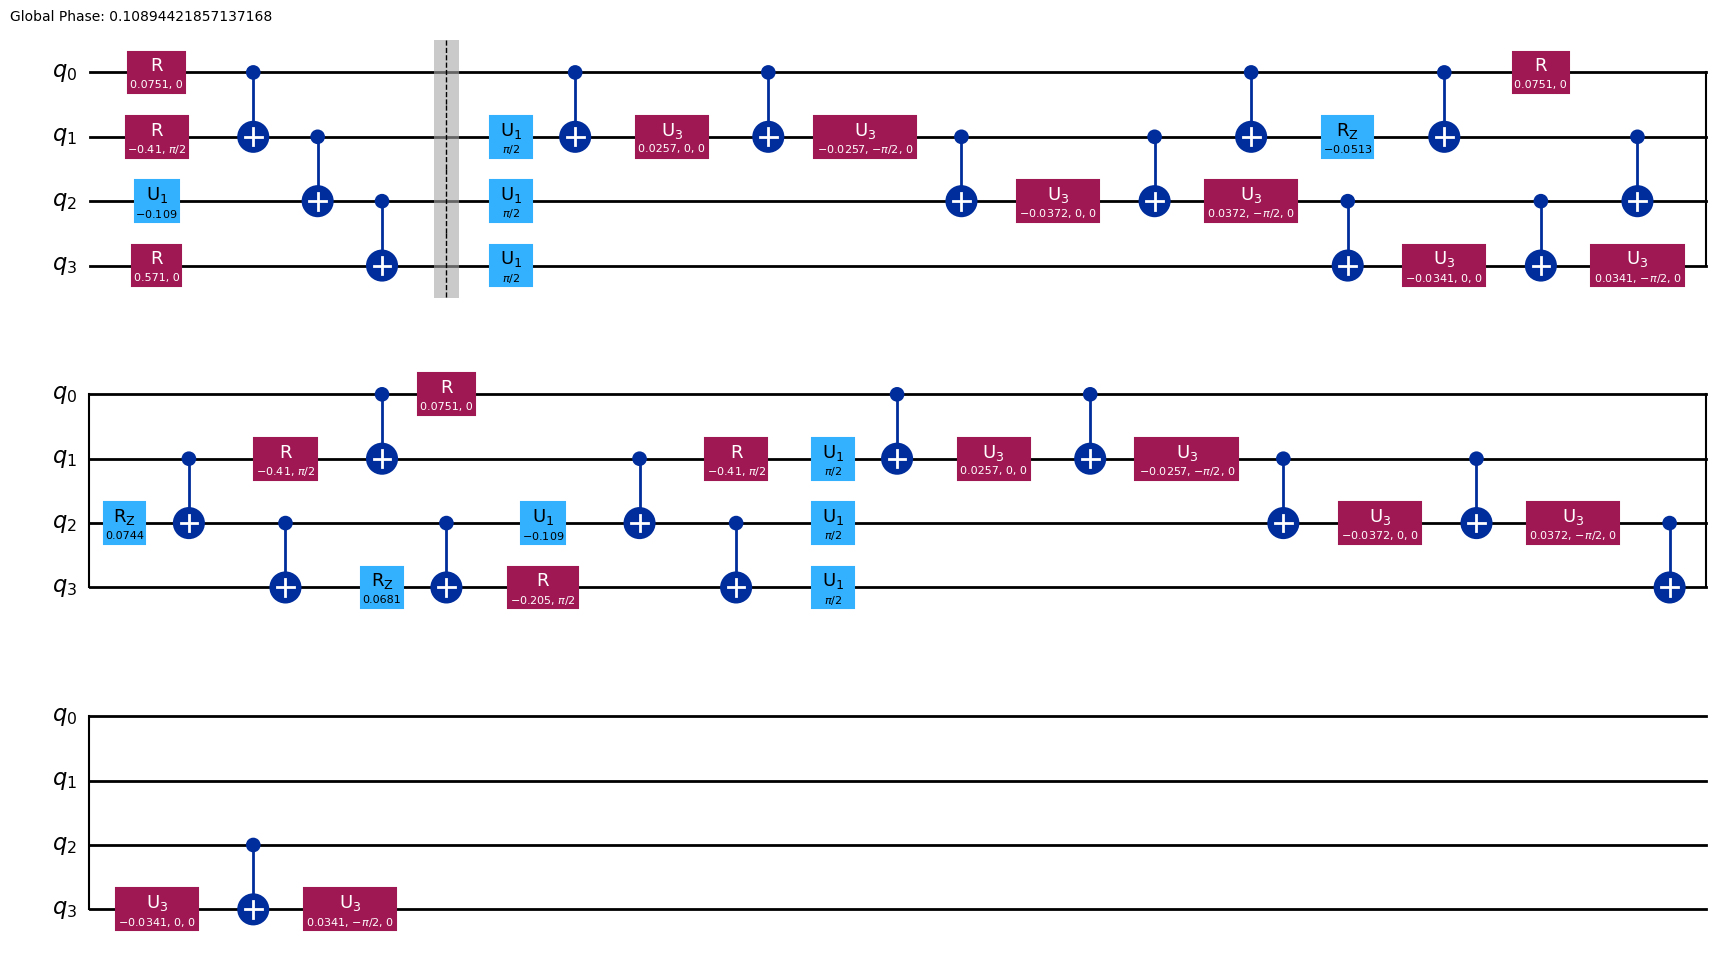

In [78]:
sv, qc, params0 = build_circuit(recipe)


In [42]:
mode = "alignment"  # "cv_acc" or "alignment"

### Entrenamientos con los distintos datasets

#### PCA

[FD] step 01 | alignment = 0.6247 | ||grad||=3.808e+00
[FD] step 02 | alignment = 0.6255 | ||grad||=7.238e-02
[FD] step 03 | alignment = 0.6262 | ||grad||=6.937e-02
[FD] step 04 | alignment = 0.6268 | ||grad||=6.649e-02
[FD] step 05 | alignment = 0.6274 | ||grad||=6.376e-02
[FD] step 06 | alignment = 0.6280 | ||grad||=6.116e-02
[FD] step 07 | alignment = 0.6285 | ||grad||=5.871e-02
[FD] step 08 | alignment = 0.6289 | ||grad||=5.639e-02
[FD] step 09 | alignment = 0.6294 | ||grad||=5.422e-02
[FD] step 10 | alignment = 0.6298 | ||grad||=5.217e-02
[FD] step 11 | alignment = 0.6301 | ||grad||=5.025e-02
[FD] step 12 | alignment = 0.6305 | ||grad||=4.846e-02
[FD] step 13 | alignment = 0.6308 | ||grad||=4.678e-02
[FD] step 14 | alignment = 0.6311 | ||grad||=4.522e-02
[FD] step 15 | alignment = 0.6314 | ||grad||=4.377e-02
[FD] step 16 | alignment = 0.6317 | ||grad||=4.242e-02
[FD] step 17 | alignment = 0.6319 | ||grad||=4.116e-02
[FD] step 18 | alignment = 0.6322 | ||grad||=4.000e-02
[FD] step 

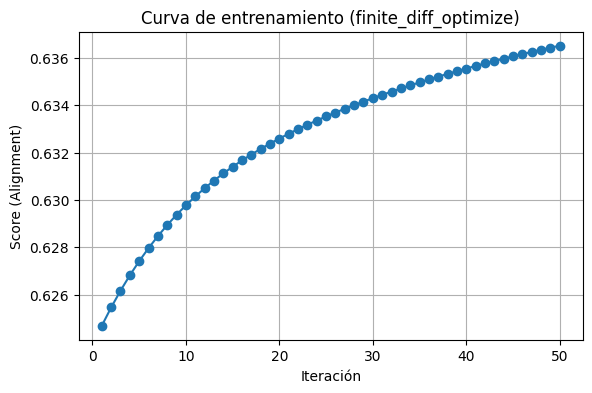

Mejores parámetros: {'g1_rx_0': -0.6815, 'g1_ry_1': 0.1906, 'g1_rz_2': 0.2778, 'g1_rx_norm': 0.1502, 'eta_crx': -0.1797, 'g2_rx_0': 0.4376, 'g2_ry_1': -0.0778, 'g2_rz_2': -0.0158, 'g2_ry_mean': 0.0124}


In [27]:
best_params, history = finite_diff_optimize(
    X_train_pi, y_train, n_qubits, recipe, params0,
    steps=50, lr=0.15, eps=1e-2, mode=mode
)

plt.figure(figsize=(6.5,4))
plt.plot(range(1, len(history)+1), history, marker="o")
plt.xlabel("Iteración"); plt.ylabel("Score " + ("(Accuracy CV)" if mode=="cv_acc" else "(Alignment)"))
plt.title("Curva de entrenamiento (finite_diff_optimize)")
plt.grid(True); plt.show()

print("Mejores parámetros:", {k: round(v,4) for k,v in best_params.items()})

Accuracy QSVM final: 0.8860


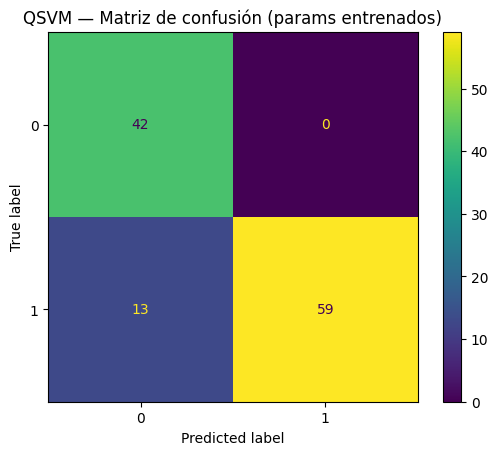

In [28]:
# 4) Evalúa QSVM final
Ktr = quantum_kernel_matrix_recipe(X_train_pi, X_train_pi, n_qubits, recipe, best_params)
Kte = quantum_kernel_matrix_recipe(X_test_pi, X_train_pi, n_qubits, recipe, best_params)
clf = SVC(kernel="precomputed", C=1.0).fit(Ktr, y_train)
acc = clf.score(Kte, y_test)
print(f"Accuracy QSVM final: {acc:.4f}")

cm = confusion_matrix(y_test, clf.predict(Kte))
ConfusionMatrixDisplay(cm).plot()
plt.title("QSVM — Matriz de confusión (params entrenados)")
plt.show()

# (Opcional) compara con gradiente por diferencias finitas:
# best_params_fd, hist_fd = finite_diff_optimize(X_tr, y_tr, n_qubits, recipe, best_params, steps=8, lr=0.08, eps=1e-2, mode=mode)
# plt.figure(); plt.plot(hist_fd, marker="o"); plt.title("Curva (Finite Differences)"); plt.show()


### FEATURE SELECTED - Criterio clinico

[FD] step 01 | alignment = 0.6938 | ||grad||=3.350e-01
[FD] step 02 | alignment = 0.7034 | ||grad||=2.674e-01
[FD] step 03 | alignment = 0.7092 | ||grad||=2.093e-01
[FD] step 04 | alignment = 0.7130 | ||grad||=1.654e-01
[FD] step 05 | alignment = 0.7155 | ||grad||=1.350e-01
[FD] step 06 | alignment = 0.7173 | ||grad||=1.145e-01
[FD] step 07 | alignment = 0.7187 | ||grad||=1.005e-01
[FD] step 08 | alignment = 0.7199 | ||grad||=9.047e-02
[FD] step 09 | alignment = 0.7209 | ||grad||=8.298e-02
[FD] step 10 | alignment = 0.7218 | ||grad||=7.715e-02
[FD] step 11 | alignment = 0.7225 | ||grad||=7.248e-02
[FD] step 12 | alignment = 0.7232 | ||grad||=6.866e-02
[FD] step 13 | alignment = 0.7238 | ||grad||=6.549e-02
[FD] step 14 | alignment = 0.7244 | ||grad||=6.281e-02
[FD] step 15 | alignment = 0.7250 | ||grad||=6.050e-02
[FD] step 16 | alignment = 0.7255 | ||grad||=5.848e-02
[FD] step 17 | alignment = 0.7259 | ||grad||=5.669e-02
[FD] step 18 | alignment = 0.7264 | ||grad||=5.506e-02
[FD] step 

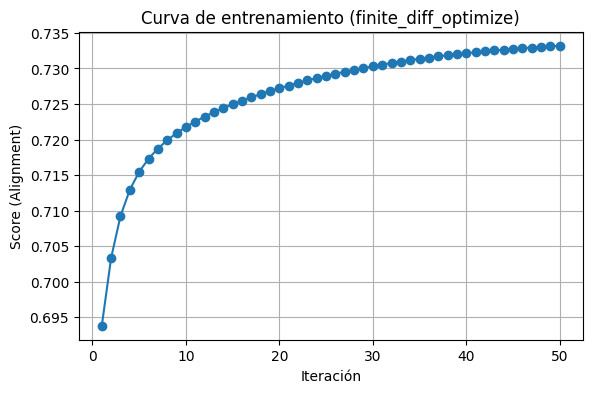

Mejores parámetros: {'g1_rx_0': 0.1277, 'g1_ry_1': -0.1962, 'g1_rz_2': -0.1235, 'g1_rx_norm': -0.5488, 'eta_crx': -0.1879, 'g2_rx_0': -0.3849, 'g2_ry_1': -0.0433, 'g2_rz_2': -0.3038, 'g2_ry_mean': -0.3128}


In [63]:
best_params, history = finite_diff_optimize(
    X_train_pi, y_train, n_qubits, recipe, params0,
    steps=50, lr=0.15, eps=1e-2, mode=mode
)

plt.figure(figsize=(6.5,4))
plt.plot(range(1, len(history)+1), history, marker="o")
plt.xlabel("Iteración"); plt.ylabel("Score " + ("(Accuracy CV)" if mode=="cv_acc" else "(Alignment)"))
plt.title("Curva de entrenamiento (finite_diff_optimize)")
plt.grid(True); plt.show()

print("Mejores parámetros:", {k: round(v,4) for k,v in best_params.items()})

Accuracy QSVM final: 0.9035


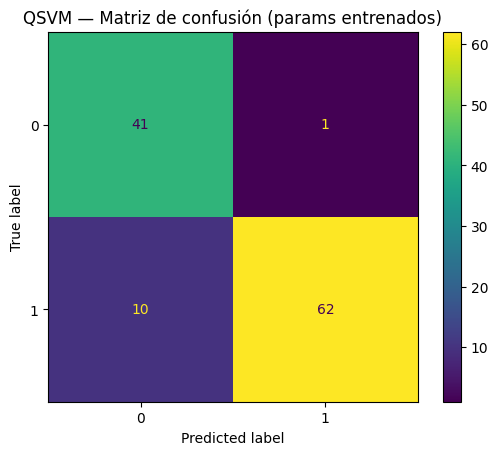

In [64]:
# 4) Evalúa QSVM final
Ktr = quantum_kernel_matrix_recipe(X_train_pi, X_train_pi, n_qubits, recipe, best_params)
Kte = quantum_kernel_matrix_recipe(X_test_pi, X_train_pi, n_qubits, recipe, best_params)
clf = SVC(kernel="precomputed", C=1.0).fit(Ktr, y_train)
acc = clf.score(Kte, y_test)
print(f"Accuracy QSVM final: {acc:.4f}")

cm = confusion_matrix(y_test, clf.predict(Kte))
ConfusionMatrixDisplay(cm).plot()
plt.title("QSVM — Matriz de confusión (params entrenados)")
plt.show()

# (Opcional) compara con gradiente por diferencias finitas:
# best_params_fd, hist_fd = finite_diff_optimize(X_tr, y_tr, n_qubits, recipe, best_params, steps=8, lr=0.08, eps=1e-2, mode=mode)
# plt.figure(); plt.plot(hist_fd, marker="o"); plt.title("Curva (Finite Differences)"); plt.show()


### RFECV_PCA

[FD] step 01 | alignment = 0.6845 | ||grad||=2.637e+00
[FD] step 02 | alignment = 0.6873 | ||grad||=1.378e-01
[FD] step 03 | alignment = 0.6900 | ||grad||=1.352e-01
[FD] step 04 | alignment = 0.6926 | ||grad||=1.322e-01
[FD] step 05 | alignment = 0.6951 | ||grad||=1.290e-01
[FD] step 06 | alignment = 0.6974 | ||grad||=1.255e-01
[FD] step 07 | alignment = 0.6996 | ||grad||=1.218e-01
[FD] step 08 | alignment = 0.7016 | ||grad||=1.181e-01
[FD] step 09 | alignment = 0.7036 | ||grad||=1.143e-01
[FD] step 10 | alignment = 0.7054 | ||grad||=1.105e-01
[FD] step 11 | alignment = 0.7070 | ||grad||=1.067e-01
[FD] step 12 | alignment = 0.7086 | ||grad||=1.030e-01
[FD] step 13 | alignment = 0.7101 | ||grad||=9.941e-02
[FD] step 14 | alignment = 0.7114 | ||grad||=9.591e-02
[FD] step 15 | alignment = 0.7127 | ||grad||=9.253e-02
[FD] step 16 | alignment = 0.7139 | ||grad||=8.926e-02
[FD] step 17 | alignment = 0.7149 | ||grad||=8.613e-02
[FD] step 18 | alignment = 0.7160 | ||grad||=8.312e-02
[FD] step 

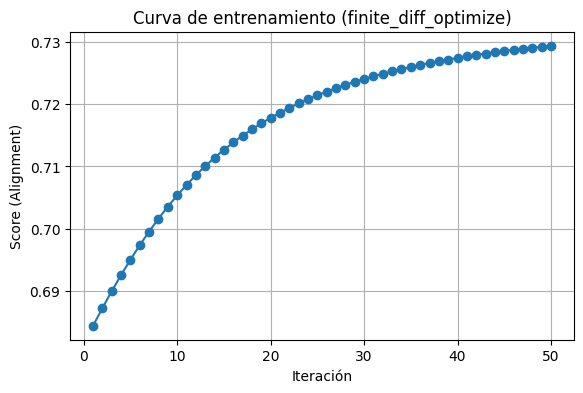

Mejores parámetros: {'g1_rx_0': 0.8332, 'g1_ry_1': 0.1029, 'g1_rz_2': 0.2965, 'g1_rx_norm': -0.2087, 'eta_crx': 0.0767, 'g2_rx_0': 0.5055, 'g2_ry_1': 0.0681, 'g2_rz_2': 0.0969, 'g2_ry_mean': 0.0308}


In [43]:
best_params, history = finite_diff_optimize(
    X_train_pi, y_train, n_qubits, recipe, params0,
    steps=50, lr=0.15, eps=1e-2, mode=mode
)

plt.figure(figsize=(6.5,4))
plt.plot(range(1, len(history)+1), history, marker="o")
plt.xlabel("Iteración"); plt.ylabel("Score " + ("(Accuracy CV)" if mode=="cv_acc" else "(Alignment)"))
plt.title("Curva de entrenamiento (finite_diff_optimize)")
plt.grid(True); plt.show()

print("Mejores parámetros:", {k: round(v,4) for k,v in best_params.items()})

Accuracy QSVM final: 0.8860


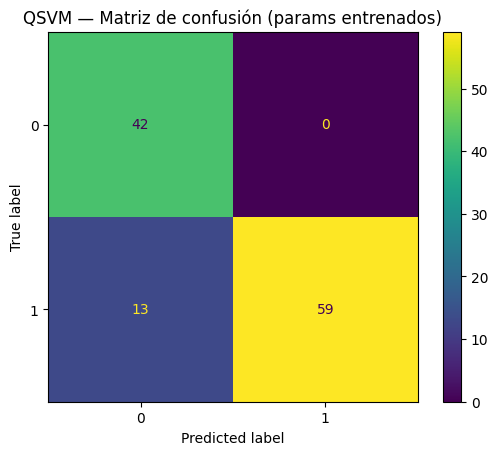

In [44]:
# 4) Evalúa QSVM final
Ktr = quantum_kernel_matrix_recipe(X_train_pi, X_train_pi, n_qubits, recipe, best_params)
Kte = quantum_kernel_matrix_recipe(X_test_pi, X_train_pi, n_qubits, recipe, best_params)
clf = SVC(kernel="precomputed", C=1.0).fit(Ktr, y_train)
acc = clf.score(Kte, y_test)
print(f"Accuracy QSVM final: {acc:.4f}")

cm = confusion_matrix(y_test, clf.predict(Kte))
ConfusionMatrixDisplay(cm).plot()
plt.title("QSVM — Matriz de confusión (params entrenados)")
plt.show()

# (Opcional) compara con gradiente por diferencias finitas:
# best_params_fd, hist_fd = finite_diff_optimize(X_tr, y_tr, n_qubits, recipe, best_params, steps=8, lr=0.08, eps=1e-2, mode=mode)
# plt.figure(); plt.plot(hist_fd, marker="o"); plt.title("Curva (Finite Differences)"); plt.show()


### ICA

[FD] step 01 | alignment = 0.5892 | ||grad||=1.741e+00
[FD] step 02 | alignment = 0.6156 | ||grad||=4.851e-01
[FD] step 03 | alignment = 0.6275 | ||grad||=2.957e-01
[FD] step 04 | alignment = 0.6359 | ||grad||=2.457e-01
[FD] step 05 | alignment = 0.6417 | ||grad||=2.061e-01
[FD] step 06 | alignment = 0.6458 | ||grad||=1.719e-01
[FD] step 07 | alignment = 0.6488 | ||grad||=1.465e-01
[FD] step 08 | alignment = 0.6512 | ||grad||=1.293e-01
[FD] step 09 | alignment = 0.6532 | ||grad||=1.172e-01
[FD] step 10 | alignment = 0.6549 | ||grad||=1.083e-01
[FD] step 11 | alignment = 0.6564 | ||grad||=1.011e-01
[FD] step 12 | alignment = 0.6577 | ||grad||=9.512e-02
[FD] step 13 | alignment = 0.6589 | ||grad||=9.002e-02
[FD] step 14 | alignment = 0.6599 | ||grad||=8.558e-02
[FD] step 15 | alignment = 0.6609 | ||grad||=8.167e-02
[FD] step 16 | alignment = 0.6618 | ||grad||=7.822e-02
[FD] step 17 | alignment = 0.6627 | ||grad||=7.515e-02
[FD] step 18 | alignment = 0.6634 | ||grad||=7.243e-02
[FD] step 

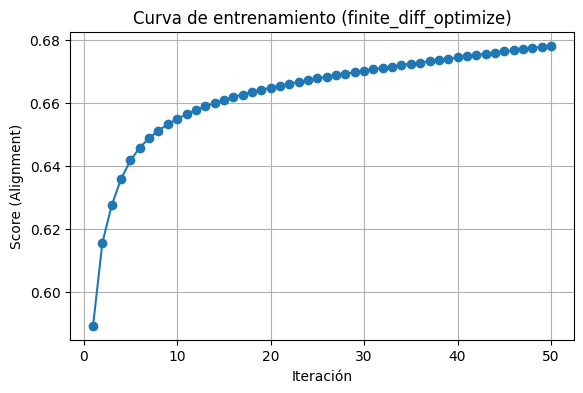

Mejores parámetros: {'g1_rx_0': -0.0898, 'g1_ry_1': 0.4348, 'g1_rz_2': -0.2256, 'g1_rx_norm': 0.1714, 'eta_crx': 0.1991, 'eta_rzz': 0.2547, 'g2_rx_0': -0.1882, 'g2_ry_1': -0.1335, 'g2_rz_2': -0.6392, 'g2_ry_mean': 0.3953, 'g3_rx_0': 0.1737, 'g3_ry_1': -0.0146, 'eta2_crx': 0.0186}


In [43]:
best_params, history = finite_diff_optimize(
    X_train_pi, y_train, n_qubits, recipe, params0,
    steps=50, lr=0.15, eps=1e-2, mode=mode
)

plt.figure(figsize=(6.5,4))
plt.plot(range(1, len(history)+1), history, marker="o")
plt.xlabel("Iteración"); plt.ylabel("Score " + ("(Accuracy CV)" if mode=="cv_acc" else "(Alignment)"))
plt.title("Curva de entrenamiento (finite_diff_optimize)")
plt.grid(True); plt.show()

print("Mejores parámetros:", {k: round(v,4) for k,v in best_params.items()})

Accuracy QSVM final: 0.8333


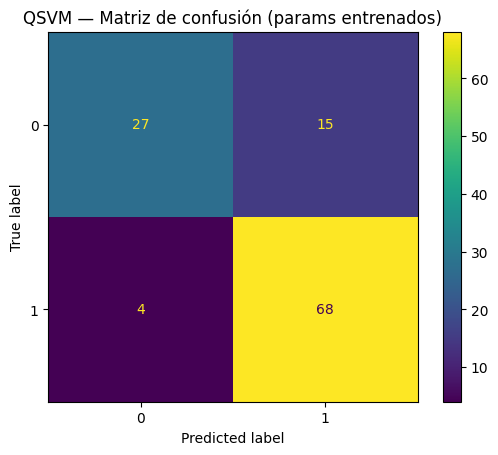

In [ ]:
# 4) Evalúa QSVM final
Ktr = quantum_kernel_matrix_recipe(X_train_pi, X_train_pi, n_qubits, recipe, best_params)
Kte = quantum_kernel_matrix_recipe(X_test_pi, X_train_pi, n_qubits, recipe, best_params)
clf = SVC(kernel="precomputed", C=1.0).fit(Ktr, y_train)
acc = clf.score(Kte, y_test)
print(f"Accuracy QSVM final: {acc:.4f}")

cm = confusion_matrix(y_test, clf.predict(Kte))
ConfusionMatrixDisplay(cm).plot()
plt.title("QSVM — Matriz de confusión (params entrenados)")
plt.show()

#### Conclusiones

- La selección de features basada en criterios clínicos fue más efectiva que PCA o ICA para este problema.
- El circuito cuántico más simple (A) logró los mejores resultados, demostrando que profundidad no siempre implica mejor desempeño en kernels cuánticos.
- La métrica de kernel alignment permitió identificar configuraciones con buena capacidad de generalización.

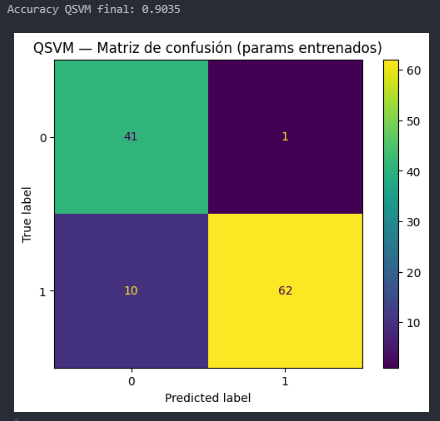
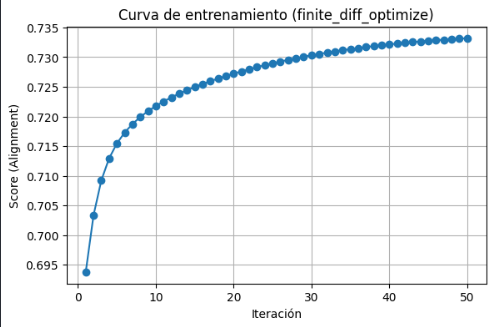